# Assembly name prediction

## Simple baseline with BERT and cosine similarity

In [105]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tqdm import tqdm
from collections import Counter
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from numpy.linalg import norm
from transformers import BertTokenizer, TFBertModel, DataCollatorForLanguageModeling
import seaborn as sns
from sklearn.metrics import top_k_accuracy_score as top_k

### Pre-process data for task

In [15]:
data_path = "data/data_02.feather"
data = pd.read_feather(data_path)

In [16]:
data = data.dropna(subset=["assembly_name", "part_names"])
data = data.drop(columns=["assembly_id", 'assembly_description'])
data.head()

,assembly_name,part_names
0,Lava Lamp 2,"[Blob3, Blob2, Blob1, Glass, Cap]"
1,Sample - Headphones,"[Pivot hinge, Headphone hinge, Telescope hinge..."
4,Coffee Mug,"[Mug, Lid]"
5,Dave's Handsome Mug,"[Lid, Seal, Vessel]"
9,Mechanical Pencil,"[Eraser, Pencil Lead, Rubber Grip, Gripper Rod..."


In [17]:
# Deduplicate
print(f"Tot: {len(data)}")
print(f"Unique: {len(data['assembly_name'].unique())}")
data = data[~data['part_names'].apply(tuple).duplicated()]
print(f"\nAfter dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name'].unique())}")

Tot: 88886
Unique: 67834

After dedup: 61725
Unique: 54034


### Clean assembly names

In [18]:
def process_assembly_names(string):
    string = string.replace('.x_t', '')
    string = string.replace('.stp', '')
    string = string.replace('.step', '')
    string = string.replace('.zip', '')
    string = ' '.join(re.findall('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', string))  # splits camelCase into camel case
    string = ' '.join(re.split('(\s+|^)([A-Za-z]+)\d+(\s+|$)', string))  # removes number at the end
    string = string.lower()
    string = string.replace('_', ' ')
    string = string.replace('-', ' ')
    string = string.replace('[', ' ')
    string = string.replace(']', ' ')
    string = string.replace('(', ' ')
    string = string.replace(')', ' ')
    string = string.replace('?', ' ')
    string = string.replace('*', ' ')
    string = string.replace('copy of', ' ')
    string = string.replace('copy', ' ')
    string = " ".join(string.split())

    return string


data['assembly_name_clean'] = data.apply(lambda row: process_assembly_names(row.assembly_name), axis=1)

In [19]:
print(f"After dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name_clean'].unique())}")

After dedup: 61725
Unique: 49601


### Clean part names

In [164]:
def process_part_names(list):
    part_names = []
    for string in list:
        if "MANIFOLD_SOLID_BREP" in string:
            return np.nan
        string = string.replace('.x_t', '')
        string = string.replace('.stp', '')
        string = string.replace('.step', '')
        string = string.replace('.dwg', '')
        string = string.replace('.zip', '')
        string = ' '.join(re.findall('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', string))  # splits camelCase into camel case
        string = ' '.join(re.split('(\s+|^)([A-Za-z]+)\d+(\s+|$)', string))  # removes number at the end
        string = string.lower()
        string = string.replace('_', ' ')
        string = string.replace('-', ' ')
        string = string.replace('[', ' ')
        string = string.replace(']', ' ')
        string = string.replace('(', ' ')
        string = string.replace(')', ' ')
        string = string.replace('?', ' ')
        string = string.replace('*', ' ')
        string = string.replace('copy of', ' ')
        string = string.replace('copy', ' ')
        string = " ".join(string.split())

        part_names.append(string)

    return part_names


data['part_names_clean'] = data.apply(lambda row: process_part_names(row.part_names), axis=1)
data.dropna(subset=['part_names_clean'], inplace=True)


In [165]:
data.head()

,assembly_name,part_names,assembly_name_clean,part_names_clean
0,Lava Lamp 2,"[Blob3, Blob2, Blob1, Glass, Cap]",lava lamp 2,"[blob, blob, blob, glass, cap]"
1,Sample - Headphones,"[Pivot hinge, Headphone hinge, Telescope hinge...",sample headphones,"[pivot hinge, headphone hinge, telescope hinge..."
4,Coffee Mug,"[Mug, Lid]",coffee mug,"[mug, lid]"
5,Dave's Handsome Mug,"[Lid, Seal, Vessel]",dave's handsome mug,"[lid, seal, vessel]"
9,Mechanical Pencil,"[Eraser, Pencil Lead, Rubber Grip, Gripper Rod...",mechanical pencil,"[eraser, pencil lead, rubber grip, gripper rod..."


### Create sentences for BERT

In [166]:
deduplicate_part_names = True

part_name_sentences = []
assembly_name_sentences = []

for index, row in tqdm(data.iterrows(), total=len(data)):
    # if len(row['part_names_clean']) > 1:
    # build single part name sentence
    part_name_sentence = "An assembly containing the following parts: "
    if deduplicate_part_names:
        part_names = set(row['part_names_clean'])
    else:
        part_names = row['part_names_clean']
    for part_name in part_names:
        part_name_sentence +=  f"{part_name}, "
    part_name_sentence = part_name_sentence[:-2] + "."
    part_name_sentences.append(part_name_sentence)

    # build single assembly name sentence
    assembly_name_sentence = f"An assembly with the name '{row['assembly_name_clean']}'"
    assembly_name_sentences.append(assembly_name_sentence)

100%|██████████| 61601/61601 [00:03<00:00, 16824.21it/s]


In [23]:
print(len(part_name_sentences))
part_name_sentences[:10]

61725


['An assembly containing the following parts: blob, cap, glass.',
 'An assembly containing the following parts: pivot hinge, telescope hinge, headphone hinge, upper band, headphone speaker.',
 'An assembly containing the following parts: mug, lid.',
 'An assembly containing the following parts: seal, vessel, lid.',
 'An assembly containing the following parts: eraser, pencil lead, gripper rod, rubber grip, button release, lead gripper.',
 'An assembly containing the following parts: block, link, peg, wheel, plate.',
 'An assembly containing the following parts: torch holder, b18.3.5m 4 x 0.7 x 10 socket fchs 10s, default, head.',
 'An assembly containing the following parts: cap, bottle base.',
 'An assembly containing the following parts: symmetry of entretoise axe corps levier, symmetry of btr m, vis de purge, vis r x2 00e9 x0 glage gauche, corps amorto rotatif, symmetry of levier, btr m, x2 00e9 x0 crou colonne, bouton d x2 00e9 x0 marrage, shock shaft, seat, human upper arm, axes m

In [24]:
print(len(assembly_name_sentences))
assembly_name_sentences[:10]

61725


["An assembly with the name 'lava lamp 2'",
 "An assembly with the name 'sample headphones'",
 "An assembly with the name 'coffee mug'",
 "An assembly with the name 'dave's handsome mug'",
 "An assembly with the name 'mechanical pencil'",
 "An assembly with the name 'os kinematics'",
 "An assembly with the name 'torch light for bike'",
 "An assembly with the name 'bottle'",
 "An assembly with the name 'concept vehicle'",
 "An assembly with the name 'mounting arm'"]

### Train test split

In [167]:
train_strings, test_strings, train_labels, test_labels = train_test_split(part_name_sentences,assembly_name_sentences, test_size=0.2)
print(f"Length of train strings: {len(train_strings)}")
print(f"Length of test strings: {len(test_strings)}")
print(f"Length of train labels: {len(train_labels)}")
print(f"Length of test labels: {len(test_labels)}")

Length of train strings: 49280
Length of test strings: 12321
Length of train labels: 49280
Length of test labels: 12321


### Tokenize and create embeddings

In [168]:
model_checkpoint = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [169]:
samples = 100
max_length = 128

test_strings_token = bert_tokenizer(test_strings[:samples],
              max_length=max_length,
              truncation=True,
              padding=True,
              return_tensors='tf')

test_labels_tokens = bert_tokenizer(test_labels[:samples],
              max_length=max_length,
              truncation=True,
              padding=True,
              return_tensors='tf')

In [170]:
test_strings_embeddings = bert_model(test_strings_token)
test_labels_embeddings = bert_model(test_labels_tokens)

In [177]:
# test_strings_embeddings_pooled = test_strings_embeddings[1]
# test_labels_embeddings_pooled = test_labels_embeddings[1]

test_strings_embeddings_cls = test_strings_embeddings[0][:, 0, :]
test_labels_embeddings_cls = test_labels_embeddings[0][:, 0, :]

### Evaluate with cosine similarity and argmax

In [184]:
# test_strings_embeddings_pooled = tf.nn.l2_normalize(test_strings_embeddings_pooled, 0)
# test_labels_embeddings_pooled = tf.nn.l2_normalize(test_labels_embeddings_pooled, 0)
test_strings_embeddings_cls = tf.nn.l2_normalize(test_strings_embeddings_cls, 0)
test_labels_embeddings_cls = tf.nn.l2_normalize(test_labels_embeddings_cls, 0)

# similarity = test_strings_embeddings_pooled @ tf.transpose(test_labels_embeddings_pooled)
similarity = test_strings_embeddings_cls @ tf.transpose(test_labels_embeddings_cls) #cls seems to work better

[Text(0.5, 47.24444444444444, 'Part Names'),
 Text(74.44444444444444, 0.5, 'Assembly Names'),
 Text(0.5, 1.0, 'Cosine Similarity Between Assembly Names and Part Names')]

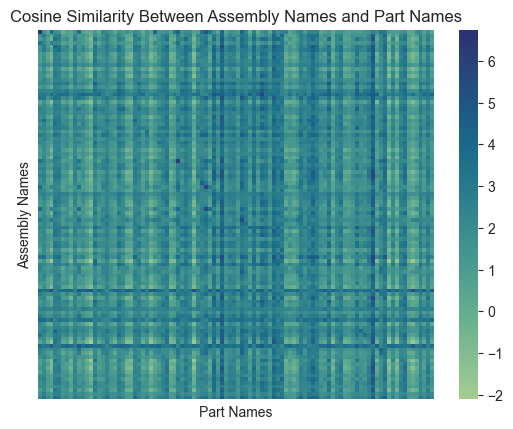

In [185]:
ax = sns.heatmap(similarity, cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")

In [186]:
pred = []
true = []
for index, value in enumerate(similarity[:10]):
    predicted = np.argmax(value)
    actual = index
    pred.append(predicted)
    true.append(actual)
    print(f"Predicted: {predicted} | Actual: {index}")

Predicted: 0 | Actual: 0
Predicted: 84 | Actual: 1
Predicted: 84 | Actual: 2
Predicted: 46 | Actual: 3
Predicted: 46 | Actual: 4
Predicted: 84 | Actual: 5
Predicted: 84 | Actual: 6
Predicted: 84 | Actual: 7
Predicted: 84 | Actual: 8
Predicted: 84 | Actual: 9


In [187]:
top_ks = [1,5,10]
for k in top_ks:
    top_k_values = np.argsort(-similarity, axis=1)[:,:k]
    correct = 0
    for index, row in enumerate(top_k_values):
        if index in row:
            correct += 1
    accuracy = correct / len(similarity)
    print(f"Top-{k} accuracy: {accuracy}")

Top-1 accuracy: 0.09
Top-5 accuracy: 0.2
Top-10 accuracy: 0.3


## Fine-tuned BERT